# DNN SOM

## Imports & Globals

In [ ]:
## Imports
from sklearn.metrics import classification_report
from ..som_tools import classifiers
from data import mfcc_arr, pca_matrix
import pickle
from collections import defaultdict
from functools import partial
from itertools import count
import numpy as np
from sklearn.model_selection import train_test_split
from minisom import MiniSom
import torch
import torch.nn as nn
import torch.optim as optim

torch.device("cuda")
torch.manual_seed(0)

## Globals
# Dataset
DATASET = "SpeakerBN"
PCA_COMPONENTS = 80
AUDIO_TIME = 0.99 #sec

# Model
SOM_NAME = "NN_SOM"
MSIZE = [16, 16]
NRADIUS = 4.0
REF_SOM_EPOCHS = 5000
SOM_EPOCHS = 50
LEARN_RATE = 0.5
NN_EPOCHS = 100
NN_BATCH = 20
CLASSES = 7
LAMBDA = 5

SyntaxError: invalid syntax (1535153863.py, line 3)

## Dataset

Create data files from raw audio

In [ ]:
mfcc_arr(DATASET, AUDIO_TIME)
pca_matrix(DATASET, AUDIO_TIME, PCA_COMPONENTS)

Processing Data


  0%|          | 0/10500 [00:00<?, ?it/s]

100%|██████████| 10500/10500 [00:30<00:00, 339.80it/s]


Data Shape: (10500, 620)


Load data files

In [60]:
with open('./data_files/' + DATASET + "/" + str(AUDIO_TIME) + "sec_" + str(PCA_COMPONENTS) + "PCA_data.p", 'rb') as infile:
#with open('./data_files/' + DATASET + "/" + str(AUDIO_TIME) + "sec_" + "data.p", 'rb') as infile:
    data = pickle.load(infile)
with open('./data_files/' + DATASET + "/" + str(AUDIO_TIME) + "sec_labels.p", 'rb') as infile:
    labels = pickle.load(infile)

print(np.shape(data))
print(np.shape(labels))

(10500, 80)
(10500,)


Format data

In [61]:
#labels = [int(i) for i in labels]
label_to_number = defaultdict(partial(next, count(1)))
y = np.zeros((len(labels), len(np.unique(labels))))
for i in range(len(labels)):
    y[i][label_to_number[labels[i]] - 1] = 1
 
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.1, train_size = 0.9, stratify=y)
X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

print(X_train.shape)
print(y_train.shape)

torch.Size([9450, 80])
torch.Size([9450, 7])


## Model

DNN

In [62]:
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(X_train.shape[1], 64)
        self.a1 = nn.ReLU()
        self.h2 = nn.Linear(64, 32)
        self.a2 = nn.ReLU()
        self.out = nn.Linear(32, CLASSES)
        self.a_out = nn.Sigmoid()
    def forward(self, x):
        x = self.a1(self.h1(x))
        x = self.a2(self.h2(x))
        x_som = torch.clone(x)
        x = self.a_out(self.out(x))
        return x, x_som
model = DNN()

print(model)

DNN(
  (h1): Linear(in_features=80, out_features=64, bias=True)
  (a1): ReLU()
  (h2): Linear(in_features=64, out_features=32, bias=True)
  (a2): ReLU()
  (out): Linear(in_features=32, out_features=7, bias=True)
  (a_out): Sigmoid()
)


DNN's SOM

In [63]:
def _no_decay(dynamic_parameter, t, max_iter):
    return dynamic_parameter


dnn_som = MiniSom(
    x             = MSIZE[0], 
    y             = MSIZE[1], 
    input_len     = 32,
    sigma         = NRADIUS,
    learning_rate = LEARN_RATE,
    decay_function= 'asymptotic_decay',
    sigma_decay_function= 'asymptotic_decay',
    random_seed   = None)

Reference SOM

In [64]:
som = MiniSom(
    x             = MSIZE[0], 
    y             = MSIZE[1], 
    input_len     = X_train[0].shape[0],
    sigma         = NRADIUS,
    learning_rate = LEARN_RATE,
    random_seed   = None)

Reference DNN

In [65]:
ref_dnn = DNN()
print(ref_dnn)

DNN(
  (h1): Linear(in_features=80, out_features=64, bias=True)
  (a1): ReLU()
  (h2): Linear(in_features=64, out_features=32, bias=True)
  (a2): ReLU()
  (out): Linear(in_features=32, out_features=7, bias=True)
  (a_out): Sigmoid()
)


## Training

DNN SOM

In [66]:
## TODO: Regular Cross Entropy Loss
## TODO: Take the bus the healys lab
## TODO: Try with CNN
## TODO: Visualization

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

with torch.no_grad():
    nn_y_pred, SOM_X_train = model(X_train)
    dnnsom_nn_y_pred_test, SOM_X_test = model(X_test)
dnn_som.random_weights_init(SOM_X_train)

epoch_x = []
dnnsom_dnn_loss_y = []
dnnsom_som_loss_y = []
dnnsom_loss_y = []
dnnsom_acc_y = []
dnnsom_som_acc_y = []

for epoch in range(NN_EPOCHS):
    epoch_x.append(epoch)

    for i in range(0, len(X_train), NN_BATCH):
        Xbatch = X_train[i:i+NN_BATCH]
        y_pred, SOM_X_batch = model(Xbatch)
        ybatch = y_train[i:i+NN_BATCH]
        loss = loss_fn(y_pred, ybatch)
        dnnsom_dnn_loss_y.append(loss.clone().detach())
        
        SOM_X_batch = SOM_X_batch.clone().detach().numpy()

        dnn_som.train_random(SOM_X_batch, SOM_EPOCHS, verbose = False)
        som_y_pred = torch.stack(classifiers.classify_BMU(dnn_som, SOM_X_batch, SOM_X_batch, ybatch), dim = 0)
        somloss = loss_fn(som_y_pred, ybatch)
        loss += somloss
        dnnsom_som_loss_y.append(somloss.clone().detach())
            

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        nn_y_pred, SOM_X_train = model(X_train)
        dnnsom_nn_y_pred_test, SOM_X_test = model(X_test)

    dnn_som_y_pred = torch.stack(classifiers.classify_BMU(dnn_som, SOM_X_test, SOM_X_train, y_train), dim = 0)
    dnnsom_som_acc_y.append((dnn_som_y_pred == y_test).float().mean())
    dnnsom_acc_y.append((nn_y_pred.round() == y_train).float().mean())
    dnnsom_loss_y.append(loss.clone().detach())

    if epoch % 10 == 0: print(f'Epoch: {epoch}| Loss: {loss}')

with torch.no_grad():
    dnnsom_nn_y_pred, SOM_X_train = model(X_train)
    dnnsom_nn_y_pred_test, SOM_X_test = model(X_test)


Epoch: 0| Loss: 2.6676883697509766
Epoch: 10| Loss: 2.5230612754821777
Epoch: 20| Loss: 2.5072760581970215
Epoch: 30| Loss: 2.4966890811920166
Epoch: 40| Loss: 2.523324489593506
Epoch: 50| Loss: 2.5116634368896484
Epoch: 60| Loss: 2.5138707160949707
Epoch: 70| Loss: 2.5102219581604004
Epoch: 80| Loss: 2.508821725845337
Epoch: 90| Loss: 2.509063720703125


Reference SOM

In [67]:
som.random_weights_init(X_train)
som.train_random(X_train, REF_SOM_EPOCHS, verbose = True)

 [ 5000 / 5000 ] 100% - -1 day, left 
 quantization error: 149.71414451411582


Reference DNN

In [68]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(ref_dnn.parameters(), lr=0.01)
 
epoch_x = []
dnn_loss_y = []
dnn_acc_y = []
for epoch in range(NN_EPOCHS):
    epoch_x.append(epoch)

    for i in range(0, len(X_train), NN_BATCH):
        Xbatch = X_train[i:i+NN_BATCH]
        y_pred, _ = ref_dnn(Xbatch)
        ybatch = y_train[i:i+NN_BATCH]
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        nn_y_pred, _ = ref_dnn(X_train)

    dnn_acc_y.append((nn_y_pred.round() == y_train).float().mean())
    dnn_loss_y.append(loss.clone().detach())
    if epoch % 10 == 0: print(f'Epoch: {epoch}| Loss: {loss}')

with torch.no_grad():
    nn_y_pred, ref_X_train = ref_dnn(X_train)
    nn_y_pred_test, _ = ref_dnn(X_test)


Epoch: 0| Loss: 1.5336970090866089
Epoch: 10| Loss: 1.478798508644104
Epoch: 20| Loss: 1.4721940755844116
Epoch: 30| Loss: 1.4593493938446045
Epoch: 40| Loss: 1.4561092853546143
Epoch: 50| Loss: 1.4552714824676514
Epoch: 60| Loss: 1.45513117313385
Epoch: 70| Loss: 1.455235242843628
Epoch: 80| Loss: 1.4550888538360596
Epoch: 90| Loss: 1.4552853107452393


## Evaluation

DNN SOM - SOM

In [69]:
dnn_som_y_pred = torch.stack(classifiers.classify_BMU(dnn_som, SOM_X_test, SOM_X_train, y_train), dim = 0)
print(classification_report(y_test, dnn_som_y_pred))
accuracy = (dnn_som_y_pred == y_test).float().mean()
print(f"DNN-SOM Test Accuracy: {accuracy}")

              precision    recall  f1-score   support

           0       0.69      0.67      0.68       150
           1       0.75      0.79      0.77       150
           2       0.68      0.58      0.63       150
           3       0.64      0.69      0.66       150
           4       0.95      0.92      0.94       150
           5       0.45      0.51      0.47       150
           6       0.53      0.50      0.52       150

   micro avg       0.66      0.66      0.66      1050
   macro avg       0.67      0.66      0.67      1050
weighted avg       0.67      0.66      0.67      1050
 samples avg       0.66      0.66      0.66      1050

DNN-SOM Test Accuracy: 0.9042176604270935


DNN SOM - DNN

In [70]:
accuracy = (dnnsom_nn_y_pred_test.round() == y_test).float().mean()
print(f"NN Test Accuracy: {accuracy}")

NN Test Accuracy: 0.8462585210800171


Reference SOM

In [71]:
som_y_pred = torch.stack(classifiers.classify_BMU(som, X_test, X_train, y_train), dim = 0)
print(classification_report(y_test, som_y_pred))
accuracy = (som_y_pred == y_test).float().mean()
print(f"SOM Test Accuracy: {accuracy}")

              precision    recall  f1-score   support

           0       0.30      0.30      0.30       150
           1       0.32      0.28      0.30       150
           2       0.49      0.46      0.48       150
           3       0.24      0.23      0.23       150
           4       0.62      0.65      0.64       150
           5       0.34      0.33      0.34       150
           6       0.28      0.33      0.30       150

   micro avg       0.37      0.37      0.37      1050
   macro avg       0.37      0.37      0.37      1050
weighted avg       0.37      0.37      0.37      1050
 samples avg       0.37      0.37      0.37      1050

SOM Test Accuracy: 0.8201360702514648


Reference DNN

In [72]:
accuracy = (nn_y_pred_test.round() == y_test).float().mean()
print(f"NN Test Accuracy: {accuracy}")

NN Test Accuracy: 0.8130612373352051


# Visualization

## Reference DNN

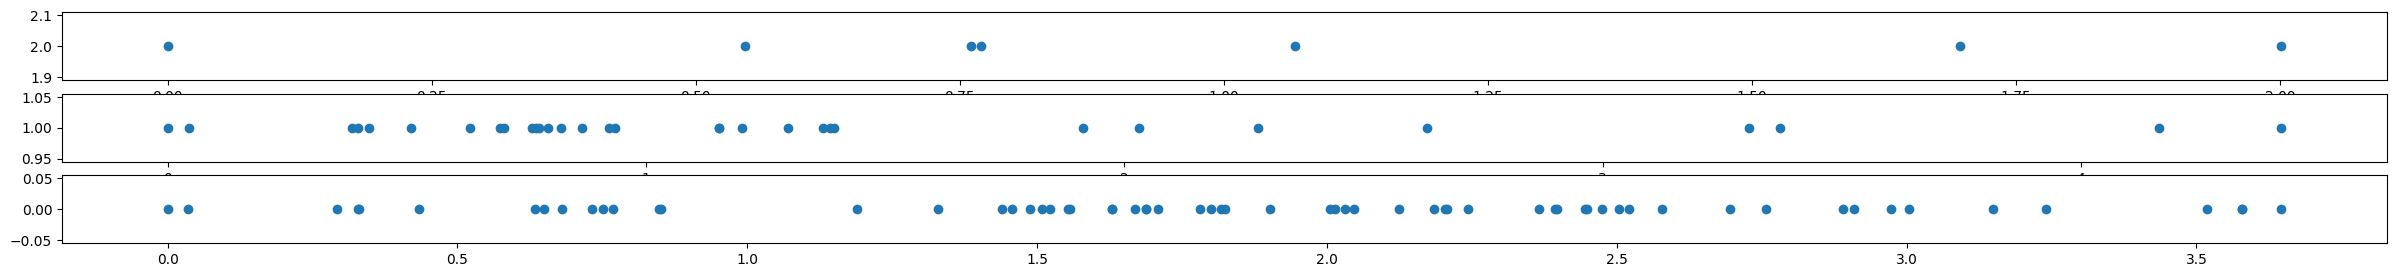

In [73]:
import math
import matplotlib.pyplot as plt

layers = [ref_dnn.h1.weight, ref_dnn.h2.weight, ref_dnn.out.weight]
x = [] 
y = []
i = 0
f, axis = plt.subplots(3, 1)
f.set_figheight(3)
f.set_figwidth(30)
for layer in layers:
    x = [] 
    y = []
    center = int(np.round(layer.shape[0]/2))
    for node in layer:
        y.append(i)
        diff = node - layer[center]
        x.append(np.abs(np.sum(diff.detach().numpy())))
    axis[2-i].scatter(x, y)
    i += 1



## DNN-SOM

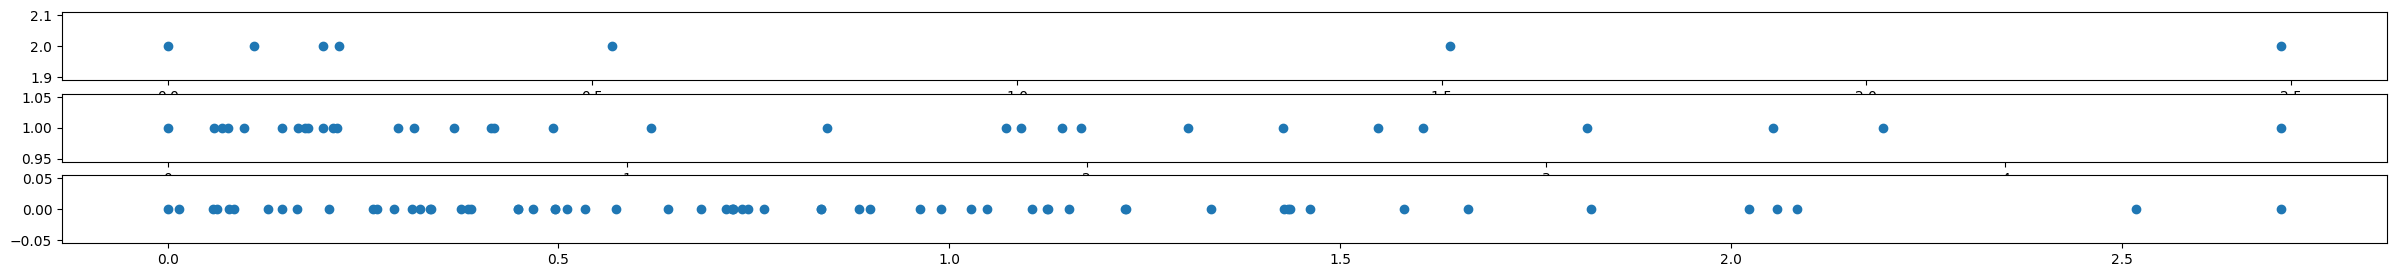

In [74]:
import math
import matplotlib.pyplot as plt

layers = [model.h1.weight, model.h2.weight, model.out.weight]
x = [] 
y = []
i = 0
f, axis = plt.subplots(3, 1)
f.set_figheight(3)
f.set_figwidth(30)
for layer in layers:
    x = [] 
    y = []
    center = int(np.round(layer.shape[0]/2))
    for node in layer:
        y.append(i)
        diff = node - layer[center]
        x.append(np.abs(np.sum(diff.detach().numpy())))
    axis[2-i].scatter(x, y)
    i += 1

## Ref SOM

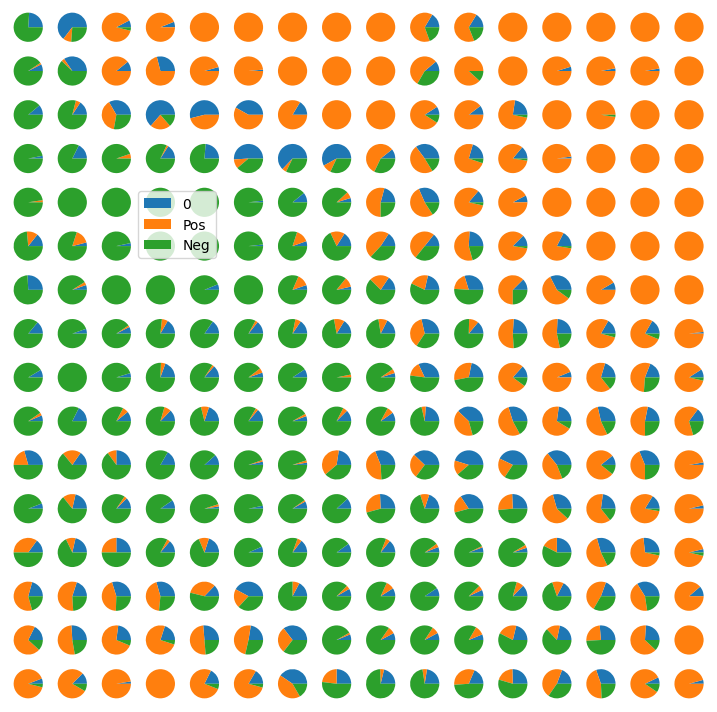

In [99]:
import matplotlib.gridspec as gridspec
new_labels = ['Neg' if int(x) < 0 else "Pos" if int(x) > 0 else "0" for x in labels]
label_names = list(set(new_labels))
labels_map = som.labels_map(data, new_labels)

fig = plt.figure(figsize=(9, 9))
the_grid = gridspec.GridSpec(MSIZE[0], MSIZE[1], fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names]
    #label_fracs = [1 if i == max(label_fracs) else 0 for i in label_fracs]
    plt.subplot(the_grid[MSIZE[0]-1-position[0], position[1]], aspect=1)
    #plt.subplot(the_grid[som.x-1-position[1], position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)

plt.legend(patches, label_names)
plt.show()

## DNN SOM

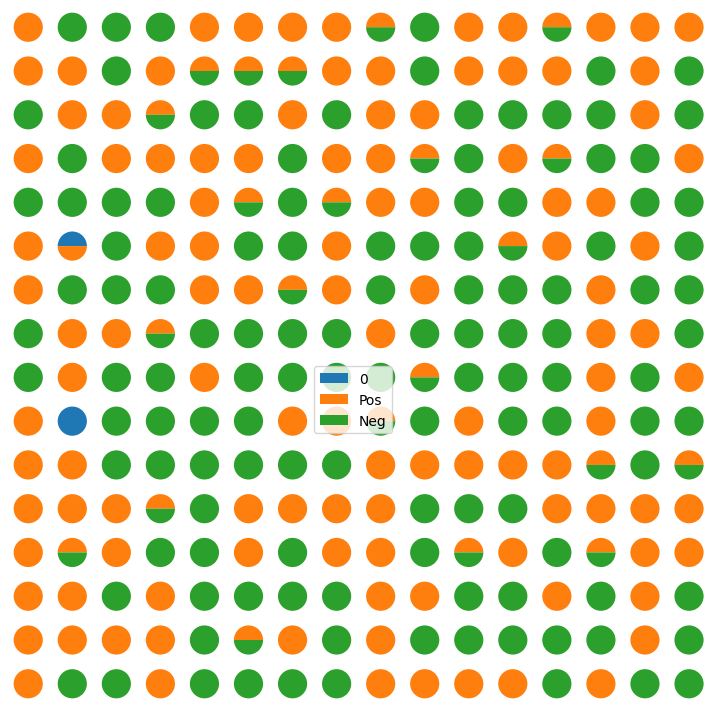

In [98]:
# TODO: Seperate Pie Charts for train/test
# TODO: Layer by Layer DNN visualizations
# TODO: Introduce lambda term to SOM
som_x = np.concatenate((SOM_X_train, SOM_X_test))

new_labels = ['Neg' if int(x) < 0 else "Pos" if int(x) > 0 else "0" for x in labels]
label_names = list(set(new_labels))
labels_map = dnn_som.labels_map(som_x, new_labels)

fig = plt.figure(figsize=(9, 9))
the_grid = gridspec.GridSpec(MSIZE[0], MSIZE[1], fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names]
    label_fracs = [1 if i == max(label_fracs) else 0 for i in label_fracs]
    plt.subplot(the_grid[MSIZE[0]-1-position[0], position[1]], aspect=1)
    #plt.subplot(the_grid[som.x-1-position[1], position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)

plt.legend(patches, label_names)
plt.show()

## Learning Curve

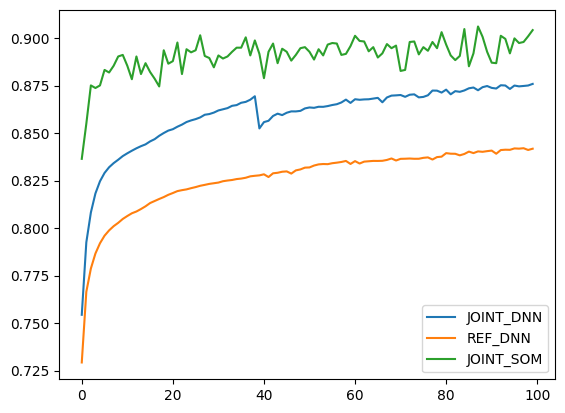

In [77]:
import matplotlib.pyplot as plt

plt.plot(epoch_x, dnnsom_acc_y)
plt.plot(epoch_x, dnn_acc_y)
plt.plot(epoch_x, dnnsom_som_acc_y)
plt.legend(["JOINT_DNN", "REF_DNN", "JOINT_SOM"])

plt.show()

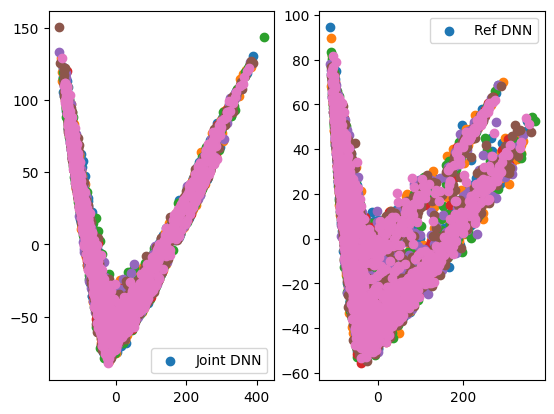

In [82]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca_joint = PCA(n_components=2)
pca_ref = PCA(n_components=2)

data_joint = pca_joint.fit_transform(SOM_X_train)
data_ref = pca_ref.fit_transform(ref_X_train)


f, axis = plt.subplots(1, 2)

for l in set(labels):
    x_joint = [data_joint[i][0] for i in range(len(data_joint)) if labels[i] == l]
    y_joint = [data_joint[i][1] for i in range(len(data_joint)) if labels[i] == l]
    x_ref = [data_ref[i][0] for i in range(len(data_ref)) if labels[i] == l]
    y_ref = [data_ref[i][1] for i in range(len(data_ref)) if labels[i] == l]
    axis[0].scatter(x_joint, y_joint, label = l)
    axis[1].scatter(x_ref, y_ref, label = l)



axis[0].legend(["Joint DNN"])
axis[1].legend(["Ref DNN"])
plt.show()




[0.79288979 0.0714996  0.0635737  0.02046292 0.00799993 0.00564603]
[0.75341114 0.12343451 0.06367251 0.01566798 0.00717724 0.00475505]


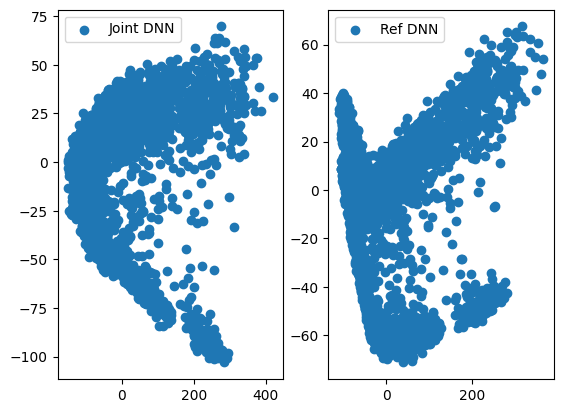

In [96]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca_joint = PCA(n_components=6)
pca_ref = PCA(n_components=6)

data_joint = pca_joint.fit_transform(SOM_X_train)
data_ref = pca_ref.fit_transform(ref_X_train)

print(pca_ref.explained_variance_ratio_)
print(pca_joint.explained_variance_ratio_)

new_labels = ['Neg' if int(x) < 0 else "Pos" if int(x) > 0 else "0" for x in labels]

f, axis = plt.subplots(1, 2)

for l in set(new_labels):
    if l == "Neg":
        x_joint = [data_joint[i][0] for i in range(len(data_joint)) if new_labels[i] == l]
        y_joint = [data_joint[i][2] for i in range(len(data_joint)) if new_labels[i] == l]
        x_ref = [data_ref[i][0] for i in range(len(data_ref)) if new_labels[i] == l]
        y_ref = [data_ref[i][2] for i in range(len(data_ref)) if new_labels[i] == l]
        axis[0].scatter(x_joint, y_joint, label = l)
        axis[1].scatter(x_ref, y_ref, label = l)



axis[0].legend(["Joint DNN"])
axis[1].legend(["Ref DNN"])
plt.show()